In [20]:
import numpy as np
from math import factorial
import strawberryfields as sf
from strawberryfields.backends.states import BaseBosonicState

from bosonicplus.states.coherent import gen_fock_coherent_fast, gen_fock_coherent, gen_fock_coherent_fast
from bosonicplus.states.wigner import get_wigner_coherent, Gauss

from bosonicplus.plotting import plot_wig

import matplotlib.pyplot as plt

from bosonicplus.quality.fidelity import fidelity_coherent, fidelity_with_wigner

In [28]:
def fc(state1, state2):
    """NEW FIDELITY FUNCTION FOR CALCULATING FIDELITY OF WIGNER AS SUM OF GAUSSIANS
    WHERE THE REAL PARTS OF THE CROSS TERMS ARE USED. NEED TO SOLVE COS*GAUSS INTEGRAL
    
    Calculate fidelity between two states in coherent representation 
    i.e. there is only one covariance matrix, but many weights and means.
    
    Args:
        state1 (BaseBosonicState):
        state2 (BaseBosonicState):
        
    Returns:
        fidelity (float): fidelity of state1 with state2, assuming one of them is pure
    """
    
    #Equal number of modes check
    if state1.num_modes != state2.num_modes:
        raise ValueError('Number of modes is not the same in both states.')

    N = state1.num_modes

    weights1 = state1.weights()
    weights2 = state2.weights()
    
    deltas = state1.means()[:,np.newaxis,:] - state2.means()[np.newaxis,:,:]

    covsum = state1.covs() + state2.covs() #covs are the same shape, so no broadcasting needed
    
    covsum_inv = np.linalg.inv(covsum)
    
    exp_arg = np.einsum('...j,...jk,...k', deltas, covsum_inv, deltas)

    weighted_exp = state1.weights()[:,np.newaxis] * state2.weights()[np.newaxis,:] 
    #sf.hbar ** N* np.sqrt( np.linalg.det(covsum)) 
                 
                     
               
    fidelity = np.sum(weighted_exp)
    #fidelity = math.fsum(weighted_exp.reshape(len(state1.weights())*len(state2.weights())))
    
    return fidelity


In [29]:
x = np.linspace(-15,15,200)
n = 20

In [30]:
m, c, w = gen_fock_coherent(n, 1e-5)
s1 = BaseBosonicState([m,c,w,], 1, len(w))
print('No of Gaussian in Wigner rep: ', len(w))
print('Norm', np.sum(w))

W1 = get_wigner_coherent(s1,x,x)

No of Gaussian in Wigner rep:  441
Norm (1-6.938893903907228e-18j)


In [31]:
m, c, w = gen_fock_coherent_fast(n,1e-4)
print('No of Gaussians in fast Wigner rep', len(w))
print('Norm', np.sum(w))
print('Norm of real parts', np.sum(w.real))

s2 = BaseBosonicState([m,c,w,], 1, len(w))
W2 = get_wigner_coherent(s2,x,x)

No of Gaussians in fast Wigner rep 231
Norm (1+0.1067839116824413j)
Norm of real parts 0.9999999999999998


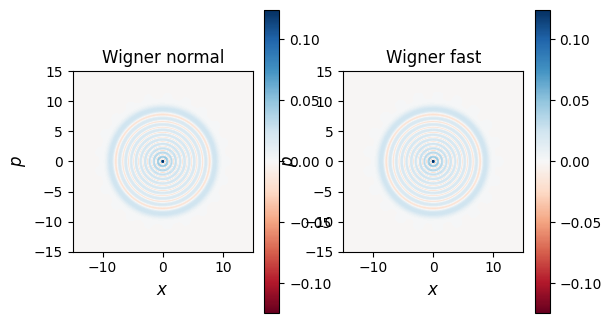

In [34]:
fig, axes = plt.subplots(1,2,)
plot_wig(axes[0], W1, x,x)
axes[0].set_title('Wigner normal')
plot_wig(axes[1], W2,x,x)
axes[1].set_title('Wigner fast')
plt.show()

In [35]:
#Fidelity functions no longer work for fast Wigner

print('Purity normal', fidelity_coherent(s1,s1))
print('Purity new fid function', fc(s1,s1))
print('Purity with wigner', fidelity_with_wigner(W1,W1,x,x))


print('Purity of fast with normal fid fun', fidelity_coherent(s2,s2))
print('Purity of fast with new fid fun', fc(s2,s2))
print('Purity of fast with wigner', fidelity_with_wigner(W2.real,W2.real,x,x))

Purity normal 0.9999999999999996
Purity new fid function (1-6.938893903907228e-18j)
Purity with wigner (1.000000000000059-3.7481716708148866e-20j)
Purity of fast with normal fid fun 0.17124496061467703
Purity of fast with new fid fun (0.9885971962057964+0.21356782336488261j)
Purity of fast with wigner 1.000000000000059
